In [86]:
import matplotlib
import matplotlib.pyplot as plt

from datasets import get_dataset

import numpy as np
np.random.seed(123)

import random
random.seed(123)

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

from keras.utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, Reshape
from keras.optimizers import Adadelta, SGD
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import label_binarize
import cv2
import pdb
import progressbar
import os
from scipy import stats
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [87]:
n_views = 5
dataset = 'australian'

In [88]:
# 1. Partition L into (v_1, v_2, ..., v_n)
def get_dset(dataset):
    ds = get_dataset(dataset, 0.7, 0.25)
    [L_x, L_y], U, [test_x, test_y] = ds.get_data()
#     L_y = np.argmax(L_y, axis=1)
#     test_y = np.argmax(test_y, axis=1)
    V = []
    for ind in range(n_views):
        left = int(ind * L_x.shape[0] / n_views)
        right = int((ind+1) * L_x.shape[0] / n_views)
        V.append([L_x[left:right], L_y[left:right]])
    return ds, [L_x, L_y], U, [test_x, test_y], V

In [89]:
# 2. Learn h_i on v_i using Learn
def get_classifiers(ds, L_x, L_y, U, test_x, test_y, V):
    H = []
    n_attr = V[0][0].shape[1]

    classifiers = [RandomForestClassifier(max_depth=2, random_state=0)
                   ,AdaBoostClassifier(),
                   GradientBoostingClassifier(),
                   KNeighborsClassifier()
                   ,MLPClassifier()]
    
    for ind in range(n_views):
        h = classifiers[ind]
        H.append(h)

    for ind in range(n_views):
        H[ind].fit(V[ind][0], np.argmax(V[ind][1],axis=1))
        print accuracy_score(np.argmax(test_y,axis=1), H[ind].predict(test_x))
    
    return H, n_attr

In [90]:
# 3
def cotrain(ds, L_x, L_y, U, test_x, test_y, V, H, n_attr):
    changed = True
    to_plot = []
    num_runs = 5
    while (changed and num_runs <= 10):
        print num_runs
        preds_L = []
        for ind in range(n_views):
            preds_L.append(H[ind].predict_proba(L_x))
        preds_L = np.array(preds_L)
        # preds_L = np.argmax(preds_L, axis=2)

        preds_U = []
        for ind in range(n_views):
            preds_U.append(H[ind].predict_proba(U))
        preds_U = np.array(preds_U)
        # preds_U = np.argmax(preds_U, axis=2)

        perfs = []
        test_preds = []
        for ind in range(n_views):
            test_preds.append(H[ind].predict_proba(test_x))
        test_preds = np.array(test_preds)
    
        for ind in range(n_views):
            perf = accuracy_score(np.argmax(test_y, axis=1), np.argmax(test_preds[ind], axis=1))
            perfs.append(perf)
        perfs.append(accuracy_score(np.argmax(test_y, axis=1),
                                np.argmax(np.sum(test_preds, axis=0), axis=1)))
        to_plot.append(perfs)

        Q = []
        update = [False for _ in range(n_views)]
        for cur in range(n_views):
            elems_take = [view_ind for view_ind in range(n_views) if view_ind != cur]
            preds_others_L = preds_L[elems_take]
            preds_others_U = preds_U[elems_take]
            # pdb.set_trace()
            acc_others_L = accuracy_score(np.argmax(L_y, axis=1), 
                                      np.argmax(np.sum(preds_others_L, axis=0), axis=1))
            acc_cur_L = accuracy_score(np.argmax(L_y, axis=1), np.argmax(preds_L[cur], axis=1))
            q_cur = [[], []]
            if acc_others_L > acc_cur_L:
                update[cur] = True
                for u_ind in range(preds_U.shape[1]):
                    sum_prediction = np.argmax(np.sum(preds_others_U[:, u_ind], axis=0))
                    if np.sum(np.argmax(preds_others_U[:, u_ind], axis=1) == sum_prediction) >= 0.5 * (n_views - 1):
                        q_cur[0].append(U[u_ind])
                        label_temp = [0, 0]; label_temp[sum_prediction] = 1
                        q_cur[1].append(label_temp)
            Q.append([np.array(q_cur[0]), np.array(q_cur[1])])
        for cur in range(n_views):
            if update[cur]:
                comb_x = np.concatenate([L_x, Q[cur][0]], axis=0)
                comb_y = np.concatenate([L_y, Q[cur][1]], axis=0)
                H[cur].fit(comb_x, np.argmax(comb_y,axis=1))

        preds_L_new = []
        for ind in range(n_views):
            preds_L_new.append(H[ind].predict_proba(L_x))

        preds_U_new = []
        for ind in range(n_views):
            preds_U_new.append(H[ind].predict_proba(U))

        # pdb.set_trace()
        same = np.array_equal(preds_L, np.array(preds_L_new)) and np.array_equal(preds_U, np.array(preds_U_new))
        changed = not same
        num_runs += 1
    return to_plot

In [91]:
def plot(to_plot, n_views, dset):
    plt.figure(figsize=(7, 7))
    plt.clf()
    handles = []
    labels = []
    for ind in range(n_views):
        ys = [x[ind] for x in to_plot]
        handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = str(ind))
        handles.append(handle)
        labels.append('Classifier %d' % ind)
    ys = [x[n_views] for x in to_plot]
    handle, = plt.plot(range(len(to_plot)), ys, marker='o', label = 'Overall')
    handles.append(handle)
    labels.append('Probability sum based')

    plt.legend(handles, labels, bbox_to_anchor=(1.04,1), loc="upper left")
    # plt.legend(handles, labels)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Iterations vs accuracy for Dataset: %s' % dset)
    plt.show()

0.760233918129
0.766081871345
0.678362573099
0.666666666667
0.590643274854
5
6
7
8
9
10


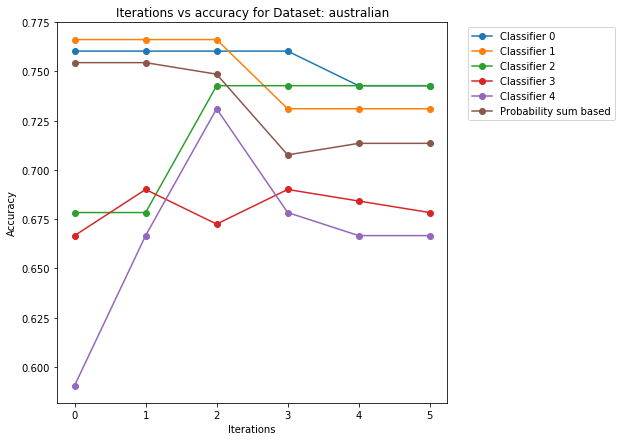

0.616279069767
0.5
0.616279069767
0.639534883721
0.616279069767
5
6
7
8
9
10


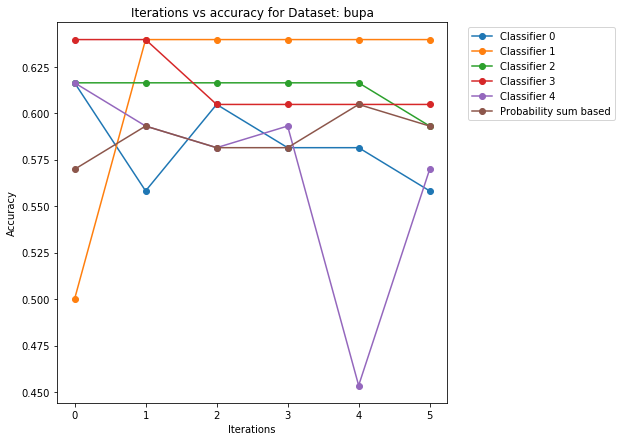

0.70652173913
0.619565217391
0.663043478261
0.728260869565
0.336956521739
5
6
7
8


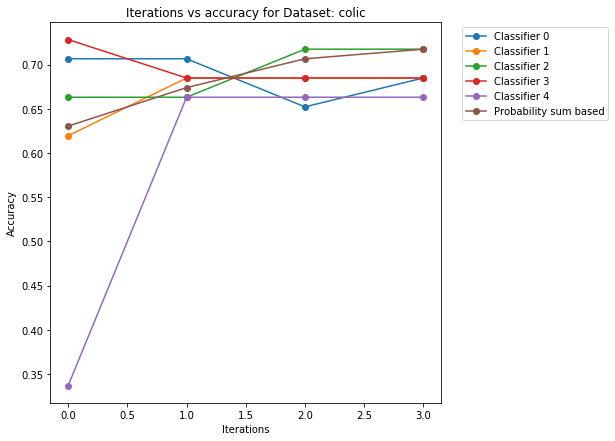

0.536458333333
0.645833333333
0.713541666667
0.661458333333
0.6875
5
6
7
8
9
10


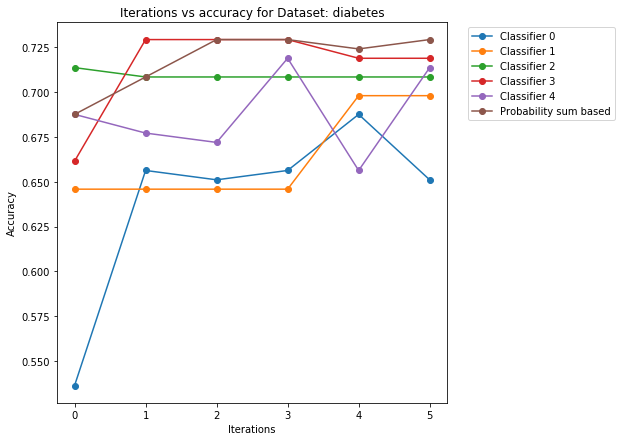

0.704
0.644
0.72
0.676
0.704
5
6
7
8
9
10


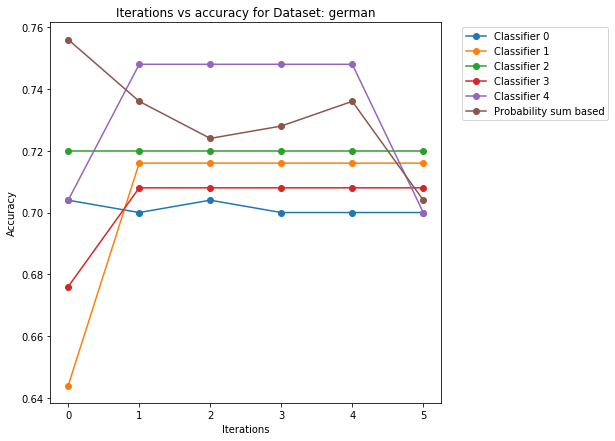

0.666666666667
0.701149425287
0.793103448276
0.64367816092
0.758620689655
5
6
7
8
9


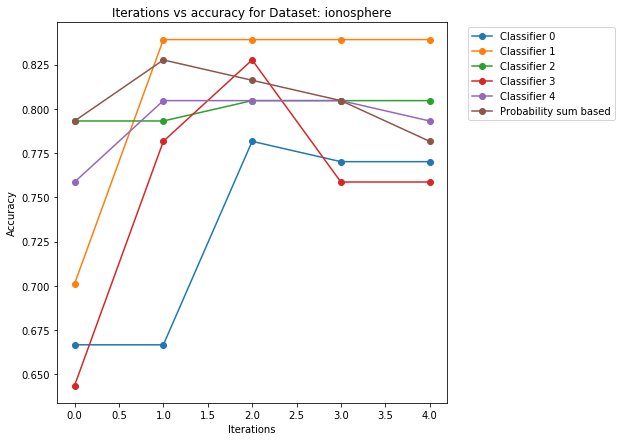

0.800751879699
0.967418546366
0.924812030075
0.748120300752
0.863408521303
5
6
7
8
9
10


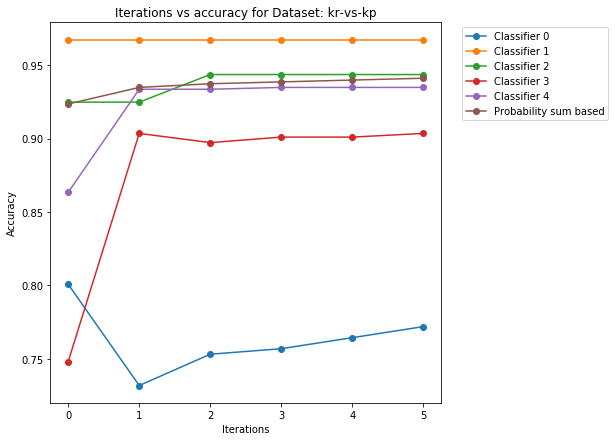

0.677824267782
0.728033472803
0.803347280335
0.665271966527
0.682008368201
5
6
7
8
9
10


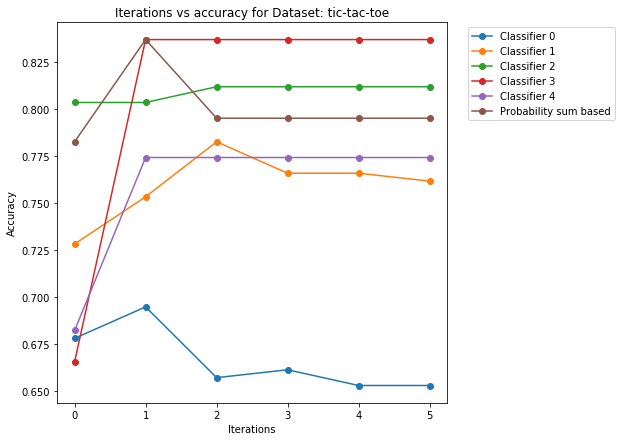

0.953703703704
0.824074074074
0.916666666667
0.907407407407
0.935185185185
5
6
7
8


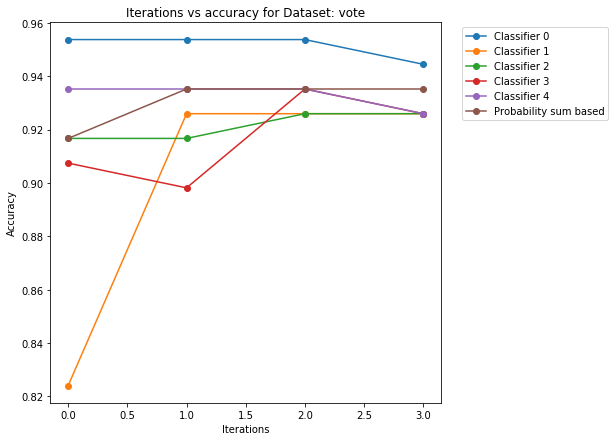

0.915492957746
0.901408450704
0.922535211268
0.605633802817
0.62676056338
5
6
7
8
9
10


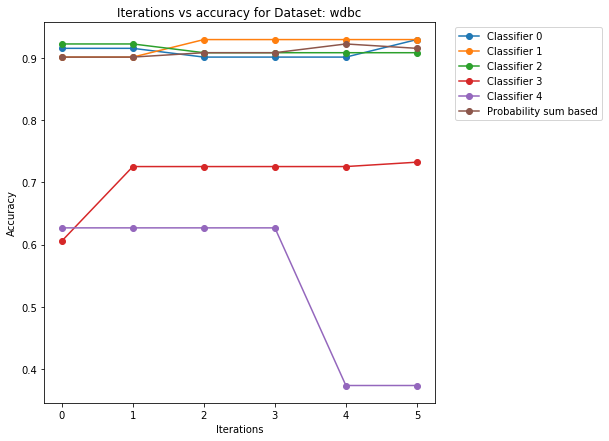

In [93]:
for dset in ['australian', 'bupa', 'colic', 'diabetes', 'german', 'ionosphere', 'kr-vs-kp', 'tic-tac-toe', 'vote', 'wdbc']:
    ds, [L_x, L_y], U, [test_x, test_y], V = get_dset(dset)
    H, n_attr = get_classifiers(ds, L_x, L_y, U, test_x, test_y, V)
    to_plot = cotrain(ds, L_x, L_y, U, test_x, test_y, V, H, n_attr)
    plot(to_plot, n_views, dset)